# 823 final project

**Project Github repository: https://github.com/JiamanBettyWu/bios823_project.** Team:ABC

This is a group project where we used the MIMIC III to predict the outcome(death or not) after admitted to ICU. There are three main sections. The first is data cleaning, preprocessing, exploratory data analysis. Second, build a logistic regression model and random forest classification model to predict primary outcome. Third, build a multilayer perceptron to predict primary outcome. This report is about the second section of our project. To see more detailed information, please visit our girhub repository provided above. Our primary outcome is **HOSPITAL_EXPIRE_FLAG**. It is a bianry outcome that HOSPITAL_EXPIRE_FLAG=0 indicates patient survived in this hospitalization and HOSPITAL_EXPIRE_FLAG=1 indicates patient died in this hospitalization.

### Build logistic regression model and random forest model to predict whether a patient dies after admitted into ICU.

by Ashley Mengyi Hu

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_auc_score, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
from numpy import mean
from numpy import std
from pprint import pprint
import math
import plotly.express as px

In [2]:
df = pd.read_csv('MIMIC_cleaned.csv')

In [3]:
age = df.AGE_ON_AD.astype(str).str.split(".", expand=True)[[0]]
age = age.astype(int)
np.sort(age[0][age[0] < 100].unique())
df["age"] = np.where(age[0] > 89, 90, age[0])

In [4]:
le = LabelEncoder()
df["gender"] = le.fit_transform(df.GENDER)

In [5]:
df["ethnicity"] = le.fit_transform(df.ETHNICITY)

### Missing data

There are several missingness in patient DIAGNOSIS. We decided to replace missing data in diagnosis with 0.

In [6]:
#replace NA with 0
df.fillna(0, inplace=True)

### train and test data split

In [9]:
y = df['HOSPITAL_EXPIRE_FLAG']

In [10]:
features_li = ['age', 'gender', 'ethnicity','ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 
               'ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
               'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']
X = df[features_li]

In [11]:
X.columns

Index(['age', 'gender', 'ethnicity', 'ICU_STAY_DAYS', 'MULTI_ENTRY_ICU',
       'ICD9_9955', 'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672',
       'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
       'PROP_ITEMID_51221', 'PROP_ITEMID_51222', 'PROP_ITEMID_51248',
       'PROP_ITEMID_51249', 'PROP_ITEMID_51250', 'PROP_ITEMID_51265',
       'PROP_ITEMID_51277', 'PROP_ITEMID_51279', 'PROP_ITEMID_51301',
       'PROP_ITEMID_50820', 'PROP_ITEMID_50868', 'PROP_ITEMID_50882',
       'PROP_ITEMID_50902', 'PROP_ITEMID_50912', 'PROP_ITEMID_50931',
       'PROP_ITEMID_50960', 'PROP_ITEMID_50970', 'PROP_ITEMID_50971',
       'PROP_ITEMID_50983', 'PROP_ITEMID_51006'],
      dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
 test_size=0.2, random_state=0)

In [13]:
#Train set
X_train.shape

(47180, 35)

In [14]:
#Test set
X_test.shape

(11796, 35)

### Stat model  logistic regression

In this section we used sm.logit from the **statmodel** package to build logistic regression model. The stat model can provide coef estimates, p-value, thus we decided to use the statmodel package instead of using the logisticregression function from sklearn package.

In [23]:
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)

In [24]:
y_train = np.array(y_train, dtype=float)

In [25]:
logit = sm.Logit(y_train, X_train, solver='lbfgs').fit()

Optimization terminated successfully.
         Current function value: 0.250280
         Iterations 12


In [26]:
#To get -log(p values)
values = list()
for i in range(35):
    value = (-1)*math.log(logit.pvalues[i])
    values.append(value)

In [27]:
#get list of p-values
p_value = list(logit.pvalues)

In [28]:
#get list of coefficients
coef = list(logit.params)

In [29]:
#To get OR
OR = list()
for i in range(35):
    exp = math.exp(logit.params[i])
    OR.append(exp)

In [55]:
features = ['age', 'gender', 'ethnicity', 'ICU_STAY_DAYS', 'MULTI_ENTRY_ICU',
       'ICD9_9955', 'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672',
       'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
       'PROP_ITEMID_51221', 'PROP_ITEMID_51222', 'PROP_ITEMID_51248',
       'PROP_ITEMID_51249', 'PROP_ITEMID_51250', 'PROP_ITEMID_51265',
       'PROP_ITEMID_51277', 'PROP_ITEMID_51279', 'PROP_ITEMID_51301',
       'PROP_ITEMID_50820', 'PROP_ITEMID_50868', 'PROP_ITEMID_50882',
       'PROP_ITEMID_50902', 'PROP_ITEMID_50912', 'PROP_ITEMID_50931',
       'PROP_ITEMID_50960', 'PROP_ITEMID_50970', 'PROP_ITEMID_50971',
       'PROP_ITEMID_50983', 'PROP_ITEMID_51006']

In [56]:
logit.summary(xname=features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                47180
Model:                          Logit   Df Residuals:                    47145
Method:                           MLE   Df Model:                           34
Date:                Wed, 24 Nov 2021   Pseudo R-squ.:                  0.2233
Time:                        20:00:52   Log-Likelihood:                -11808.
converged:                       True   LL-Null:                       -15203.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0015      0.001     -1.693      0.090      -0.003       0.000
gender               -0.3030      0.035     -8.760      0.000      -0.371      -0.235
ethnicity            -0.0526      0.001    -37.020      0.000      -0.055      -0.050
ICU_STAY_DAYS        -0.0330      0.003    -12.024      0.000      -0.038      -0.028
MULTI_ENTRY_ICU      -0.4389      0.044    -10.028      0.000      -0.525      -0.353
ICD9_9955            -6.1602      0.710     -8.680      0.000      -7.551      -4.769
ICD9_3893            -0.0314      0.033     -0.960      0.337      -0.096       0.033
ICD9_9604             0.0792      0.049      1.610      0.107      -0.017       0.176
ICD9_966             -0.2444      0.051     -4.780      0.000      -0.345      -0.144
ICD9_9672             1.6592      0.066     25.320      0.000       1.531       1.788
ICD9_9904             0.0831      0.050      1.670      0.095      -0.014       0.181
ICD9_9671             1.0128      0.052     19.437      0.000       0.911       1.115
ICD9_3961            -1.2520      0.102    -12.333      0.000      -1.451      -1.053
ICD9_8856            -0.1380      0.069     -1.989      0.047      -0.274      -0.002
ICD9_3891             0.3440      0.049      7.025      0.000       0.248       0.440
PROP_ITEMID_51221    -0.6713      0.115     -5.828      0.000      -0.897      -0.446
PROP_ITEMID_51222    -0.9473      0.107     -8.860      0.000      -1.157      -0.738
PROP_ITEMID_51248    -0.2517      0.060     -4.200      0.000      -0.369      -0.134
PROP_ITEMID_51249    -0.4173      0.063     -6.649      0.000      -0.540      -0.294
PROP_ITEMID_51250    -0.2573      0.070     -3.663      0.000      -0.395      -0.120
PROP_ITEMID_51265     0.7674      0.050     15.478      0.000       0.670       0.865
PROP_ITEMID_51277     0.1819      0.045      4.043      0.000       0.094       0.270
PROP_ITEMID_51279    -0.7037      0.091     -7.766      0.000      -0.881      -0.526
PROP_ITEMID_51301     0.9536      0.049     19.513      0.000       0.858       1.049
PROP_ITEMID_50820     0.6368      0.049     12.916      0.000       0.540       0.733
PROP_ITEMID_50868     1.6488      0.101     16.273      0.000       1.450       1.847
PROP_ITEMID_50882     0.4671      0.059      7.889      0.000       0.351       0.583
PROP_ITEMID_50902    -0.1907      0.064     -2.993      0.003      -0.316      -0.066
PROP_ITEMID_50912     0.2680      0.057      4.696      0.000       0.156       0.380
PROP_ITEMID_50931    -0.2988      0.062     -4.802      0.000      -0.421      -0.177
PROP_ITEMID_50960     0.3002      0.093      3.233      0.001       0.118       0.482
PROP_ITEMID_50970    -0.0653      0.062     -1.054      0.292      -0.187       0.056
PROP_ITEMID_50971     0.1124      0.097      1.164      0.244      -0.077       0.302
PROP_ITEMID_50983     1.4826      0.076     19.561      0.000       1.334       1.631
PROP_ITEMID_51006     0.8922      0.062     14.364      0.0

In [32]:
data_tuples = list(zip(features, coef, OR, p_value, values))
est = pd.DataFrame(data_tuples, columns=['features','coef', 'OR','p_value','-log(p_value)'])

In [33]:
#features sorted by coefficient 
est.sort_values(by=['OR'], ascending=False)

,features,coef,OR,p_value,-log(p_value)
9,ICD9_9672,1.659162,5.254905,1.935743e-141,324.004007
25,PROP_ITEMID_50868,1.648826,5.200871,1.522623e-59,135.432086
33,PROP_ITEMID_50983,1.482553,4.404175,3.334329e-85,194.515461
11,ICD9_9671,1.012778,2.753240,3.721535e-84,192.103011
23,PROP_ITEMID_51301,0.953615,2.595075,8.566025e-85,193.571929
34,PROP_ITEMID_51006,0.892219,2.440540,8.720228e-47,106.055854
20,PROP_ITEMID_51265,0.767410,2.154180,4.907224e-54,122.748887
24,PROP_ITEMID_50820,0.636820,1.890460,3.673814e-38,86.197003
26,PROP_ITEMID_50882,0.467059,1.595296,3.055425e-15,33.421858
14,ICD9_3891,0.344044,1.410641,2.136329e-12,26.871932


In [62]:
sm_pred = logit.predict(X_test).round()

array([0., 0., 1., ..., 0., 0., 0.])

In [61]:
cnf_matrix = metrics.confusion_matrix(y_test,  sm_pred.round())

Text(0.5, 225.76, 'Predicted label')

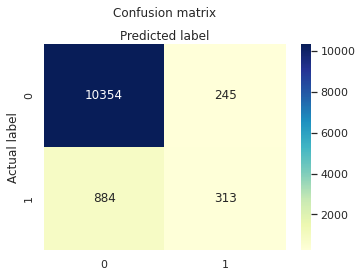

In [58]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
print("Statmodel Logistic auc score:", roc_auc_score(y_test, sm_pred.round()))

Statmodel Logistic auc score: 0.6191858313582805


In [38]:
print("Statmodel Logistic Accuracy:", accuracy_score(y_test, sm_pred.round()))
print("Statmodel Logistic Precision:", precision_score(y_test, sm_pred.round()))
print("Statmodel Logistic Recall:", recall_score(y_test, sm_pred.round()))
print(classification_report(y_test, sm_pred.round()))

Statmodel Logistic Accuracy: 0.9042895896914208
Statmodel Logistic Precision: 0.5609318996415771
Statmodel Logistic Recall: 0.26148705096073516
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10599
           1       0.56      0.26      0.36      1197

    accuracy                           0.90     11796
   macro avg       0.74      0.62      0.65     11796
weighted avg       0.88      0.90      0.89     11796



### Random forest hyperparameter tuning

First do a grid search to get the parameters that give the highest AUC score. We assigned three tree numbers and 4 max depth.

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100,500, num = 3)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True]
class_weight = ["balanced", "balanced_subsample"]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'class_weight': class_weight}
pprint(random_grid)

{'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [100, 300, 500, None],
 'n_estimators': [600, 800, 1000]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
random.seed(2021)
randomforest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomforest,
                               param_distributions = random_grid, 
                               n_iter = 1000, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='roc_auc').fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning:

The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 14.0min finished


In [41]:
#best params from grid search
rf_random.best_params_

{'n_estimators': 1000, 'max_depth': None, 'class_weight': 'balanced'}

In [42]:
y_pred = rf_random.best_estimator_.predict(X_test)

In [43]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 225.76, 'Predicted label')

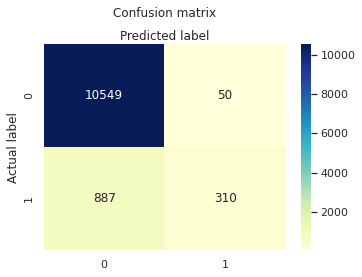

In [44]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [45]:
print("Random forest auc score:", roc_auc_score(y_test, y_pred))

Random forest auc score: 0.6271316795621471


In [46]:
print("Random forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random forest Precision:", precision_score(y_test, y_pred))
print("Random forest Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Random forest Accuracy: 0.9205662936588674
Random forest Precision: 0.8611111111111112
Random forest Recall: 0.25898078529657476
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10599
           1       0.86      0.26      0.40      1197

    accuracy                           0.92     11796
   macro avg       0.89      0.63      0.68     11796
weighted avg       0.92      0.92      0.90     11796



We built a random forest model with tree=1000 and balanced class weight.

In [47]:
feature_imp = pd.Series(rf_random.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)

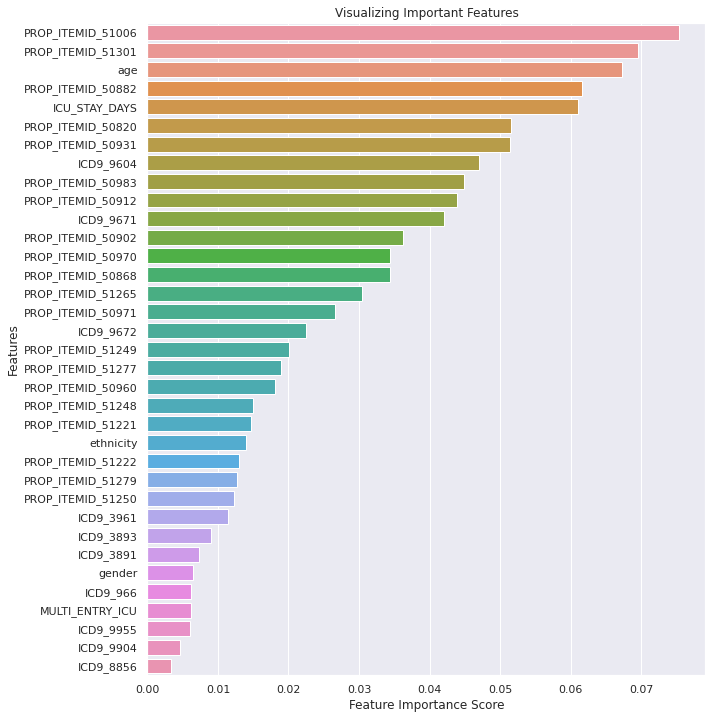

In [48]:
sns.set(rc={'figure.figsize':(10,12)})
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

This logistic regression model achived **accuracy=0.9043**, **Precision=0.5609**, **Recall=0.2615**, **AUC score=0.6192**. Based on the summary above, we identified 29 significant features that are associated with our primary outcome. The top five features that are mostly associated with death in ICU are **Cont inv mec ven 96+ hrs （ICD9_9672)**, **Anion Gap (Item 50868)**, **Sodium (Item 50983)**, **Cont inv mec ven <96 hrs (ICD9_9671)**, **51301 White Blood Cells**.

This random forest classification achieved **accuracy=0.9206**, **Precision=0.8611**, **Recall=0.2590** and **AUC score=0.6271**. The top 5 most important features are **Urea Nitrogen (labitem_51006)**, **White Blood Cells (labitem_51301)**, **age**, **Bicarbonate (labitem_50882)**, **Icu stay in days**. 

The two models gave very different feature estimation. Only White Blood Cells (labitem_51301) was selected by both models as the top five important features. We found that the random forest has higher AUC score, higher precision and higher accuracy. In this project, the random forest has better performance on predicting whether a person would die after admitted to ICU.

### Model performance

Here I included the scores of MLP as well.

|           | Logistics regression | Random Forest |  MLP |
|:---------:|:--------------------:|:-------------:|:----:|
|    AUC    |         0.62         |      0.63     | 0.71 |
|  Accuracy |         0.90         |      0.92     | 0.92 |
|    F1     |         0.36         |      0.40     | 0.55 |
| Precision |         0.56         |      0.86     | 0.71 |
|   Recall  |         0.26         |      0.26     | 0.44 |

MLP gives the highest AUC score, F1 score. Random forest has lower Recall.

Self-reflection: In this project I learned how modeling works in dealing with real life problem. My main responsibility for this project is to train a logistic regression model and a random forest model. In doing the random forest model, I used hyperparameter tuning to perform a grid search to find the proper parameter to build the random forest model. We also used the scoring = roc_auc to select the parameters that gives the highest auc score. My team members helped me a lot in building these two models. We had regular weekly meetings to discuss about our progress and make the process went smoothly.
    